# Machine learning da base

Nesse arquivo a gente vai completar com modelos de regressão lineares o projeto da base que estamos trabalhando no arquivo 01 e 02 e aumentar os tratamento do que a gente fez no 3

## Importações da bases e dependências

In [1]:
import pandas as pd
import seaborn as sns

import plotly.express as px

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import  ElasticNet, LinearRegression
from sklearn.preprocessing import (
    OrdinalEncoder, OneHotEncoder, PolynomialFeatures, PowerTransformer,
    RobustScaler, StandardScaler, QuantileTransformer
)
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos, plot_residuos_estimador
from src.models import treinar_e_validar_modelo_regressao, organiza_resultados, grid_search_cv_regressor


In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedroomns_per_room        17564 non-null  floa

## Ajustando a natureza das categorias

A primeira coisa, após o tratamento, é entender a natureza das categorias, se elas são categóricas ou não, qual é o target e, assim, definir o melhor preprocessing para nossas features.

Na nossa base, o objetivo é prever o preço médio das casas; portanto, o target é *median_house_value*.

In [3]:
coluna_target = ['median_house_value']

### Colunas categóricas

Conforme discutido no arquivo de análise e tratamento, este nosso dataframe possui duas colunas categóricas: `ocean_proximity` e `median_income_cat`.

A coluna de renda mediana foi dividida por nós em categorias com o intuito de criar maior correlação com nosso target, enquanto a proximidade com o oceano já nasceu categórica por si mesma. Entretanto, elas apresentam duas formas distintas de categorias: enquanto a renda mediana é ordenada, a proximidade com o oceano não é, o que faz com que tenhamos que usar tratamentos diferentes.


In [4]:
coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_enconder = ['median_income_cat']

colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_enconder)


O preprocessor **OneHotEncoder** é capaz de transformar variáveis categóricas nominais em representações binárias (0 e 1), criando uma coluna para cada categoria possível. Por isso, escolhemos utilizá-lo nessa coluna categórica, pois não há relação de ordem entre as categorias e precisamos evitar que o modelo interprete valores como hierárquicos.

O preprocessor **OrdinalEncoder** é capaz de converter categorias em valores numéricos inteiros preservando uma relação de ordem predefinida entre elas. Por isso, escolhemos utilizá-lo nessa coluna categórica, pois as categorias possuem hierarquia explícita e essa informação ordinal deve ser mantida para o modelo.


### Processamento

In [5]:
pipeline_robust = Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
]) 

preprocessamento =  ColumnTransformer(transformers=[
    ("one_hot_encoder", OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder), 
    ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler)
])

In [6]:
X = df.drop(columns=coluna_target)

y = df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedroomns_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3]
}

In [9]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), 
    preprocessor= preprocessamento, 
    target_transformer= QuantileTransformer(output_distribution='normal'),
    param_grid= param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Você pode questionar o motivo de existir um `target_transformer`, já que estamos testando múltiplas possibilidades no Grid Search. Nesse contexto, ele serve apenas como um valor inicial padrão para instanciar o `TransformedTargetRegressor`, pois as diferentes transformações efetivamente avaliadas são definidas e sobrescritas pelo `param_grid`.


In [10]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

In [12]:
grid_search.best_score_

-51121.39021356257

In [13]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

#extraindo os coeficientes do modelo linear vencedor do Grid Search e associando cada coeficiente ao respectivo nome de variável após o pré-processamento.

,coeficiente
robust_scaler_poly__longitude total_rooms,-313559.324908
robust_scaler_poly__housing_median_age total_rooms,-227764.456546
robust_scaler_poly__latitude total_rooms,-220335.164232
robust_scaler_poly__rooms_per_household total_bedrooms,-215048.697499
robust_scaler_poly__latitude population_per_household total_rooms,-210169.476283
...,...
robust_scaler_poly__median_income total_bedrooms,166517.472370
robust_scaler_poly__longitude population,172679.588671
robust_scaler_poly__latitude population rooms_per_household,211534.525842
robust_scaler_poly__bedroomns_per_room households,221537.436450


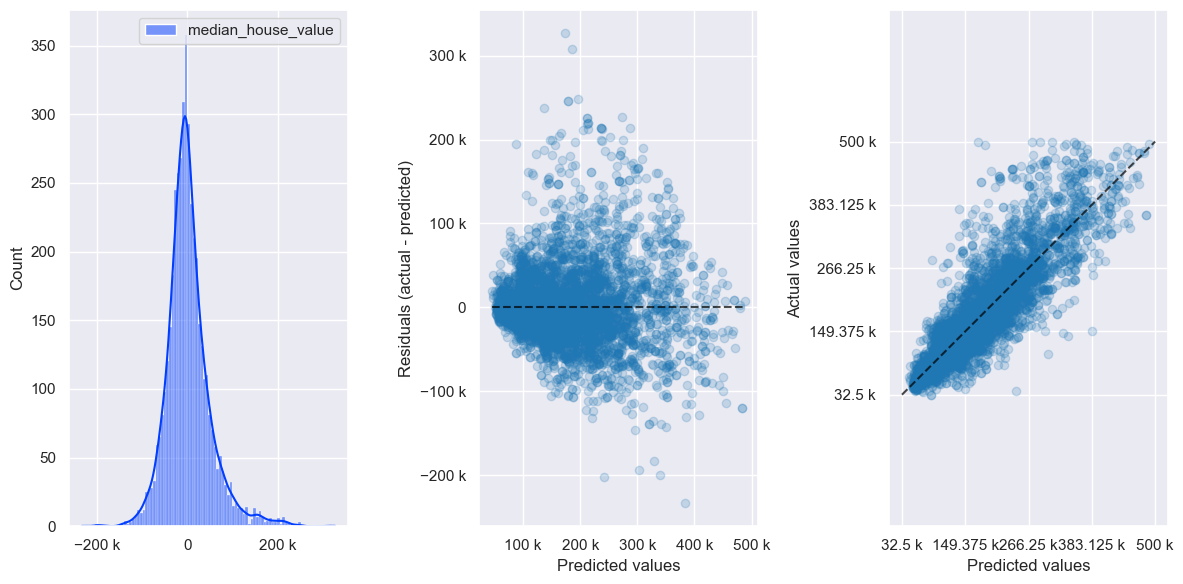

In [15]:
plot_residuos_estimador(grid_search.best_estimator_, X, y,  eng_formatter=True)